# CWT & STFT + CNN Model with Unicorn Hybrid Black dataset

In [200]:
import mne
import numpy as np
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage

raw_each = [0] * 5

for i in range(0,5):
    raw_each[i] = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\hand"+ str(i) +"_new.edf",preload = True)

# raw_edf = mne.concatenate_raws(raw_each)
raw_edf = mne.concatenate_raws([raw_each[3],raw_each[2]])
# raw_edf = raw_edf.copy().resample(62.5 ,npad="auto")

eegbci.standardize(raw_edf)  # set channel names
montage = make_standard_montage("standard_1005")
raw_edf.set_montage(montage)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand0_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand1_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand2_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand3_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand4_n

<RawEDF | hand3_new.edf, 8 x 279250 (1117.0 s), ~17.1 MB, data loaded>

In [201]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Activation
from keras.models import Sequential
from keras.callbacks import History,ModelCheckpoint
from keras.utils import plot_model
history = History()
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict
from ssqueezepy import ssq_cwt, ssq_stft
import pickle
import seaborn as sns

In [202]:
eeg1 = raw_edf.copy().filter(l_freq=1.0, h_freq=30.0, method = 'iir', iir_params= {"order": 5, "ftype":'butter'})
# eeg1 = raw_edf.copy().filter(l_freq=0.075, h_freq=3.0, method = 'fir')
eeg1 = eeg1.copy().set_eeg_reference(ref_channels="average")

eeg1= eeg1.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','PO8'])
# eeg1= eeg1.pick_channels(["C3", "Cz", "C4"])
events, event_dict = mne.events_from_annotations(eeg1)
combine_epochs = mne.Epochs(eeg1, events, 
        tmin=-5.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=5.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop'
    )

combine_epochs = combine_epochs.copy().crop(tmin=0.0, tmax=2.0)
component_num = 7

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
605 matching events found
Setting baseline interval to [-5.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 605 events and 2501 original time points ...
2 bad epochs dropped


In [203]:
df_left = combine_epochs['OVTK_GDF_Left'].to_data_frame()
df_right = combine_epochs['OVTK_GDF_Right'].to_data_frame()
df_up = combine_epochs['OVTK_GDF_Up'].to_data_frame()
df_tongue = combine_epochs['OVTK_GDF_Tongue'].to_data_frame()
df_left =df_left.iloc[:, -7:]
df_right =df_right.iloc[:, -7:]
df_up =df_up.iloc[:, -7:]
df_tongue =df_tongue.iloc[:, -7:]

# # Plot histograms for all columns in the DataFrame using Seaborn
# fig, ax = plt.subplots(1, len(df_left.columns),sharey=True, figsize=(10 * len(df_left.columns), 10))
# for i, column in enumerate(df_left.columns):
#     ax[i] = sns.histplot(df_left[column], kde=False, ax=ax[i], color= 'orange')
#     ax[i] = sns.histplot(df_right[column], kde=False, ax=ax[i], color= 'blue')
#     ax[i] = sns.histplot(df_up[column], kde=False, ax=ax[i], color= 'green')
#     ax[i] = sns.histplot(df_tongue[column], kde=False, ax=ax[i], color= 'pink')
#     ax[i].set_xlabel(column,  fontsize=30)
#     ax[i].set_ylabel('Frequency',  fontsize=30)
#     ax[i].tick_params(axis='both', labelsize=30)

# plt.tight_layout()
# plt.show()

In [204]:
df_left

,Fz,C3,Cz,C4,Pz,PO7,PO8
0,3.240880e+06,-1.108567e+06,-4.573295e+06,2.545658e+06,-9.292928e+05,-1.895764e+06,3.882685e+06
1,1.475761e+06,-4.784443e+04,-5.948709e+06,1.966786e+06,-7.506584e+05,-1.524809e+06,4.913479e+06
2,-3.476897e+05,7.497217e+05,-7.252058e+06,1.486766e+06,-1.242617e+06,-3.915461e+05,5.349052e+06
3,-2.161606e+06,1.152750e+06,-7.263610e+06,1.360105e+06,-2.797227e+06,1.082502e+06,4.594975e+06
4,-3.086864e+06,1.451731e+06,-6.168385e+06,1.175863e+06,-4.658001e+06,2.297228e+06,3.026116e+06
...,...,...,...,...,...,...,...
15025,3.727114e+06,-3.308668e+06,-2.122156e+06,-1.469832e+06,-6.383080e+05,-8.516257e+04,1.682217e+06
15026,3.244893e+06,-4.605964e+06,-2.604774e+06,-1.531452e+06,-1.605242e+06,-1.667763e+05,3.040016e+06
15027,2.689572e+06,-5.630288e+06,-2.751149e+06,-5.396404e+05,-2.450266e+06,-7.774696e+05,3.972512e+06
15028,2.474360e+06,-5.690633e+06,-2.631251e+06,9.798824e+05,-2.612491e+06,-2.185190e+06,4.440110e+06


In [205]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Example DataFrame (replace this with your actual DataFrame)
# data = {
#     'column1': [1, 2, 3, 4, 5],
#     'column2': [2, 3, 4, 5, 6],
#     'column3': [3, 4, 5, 6, 7],
#     'column4': [4, 5, 6, 7, 8],
#     'column5': [5, 6, 7, 8, 9]
# }
# df = pd.DataFrame(data)

# # Select the last three columns
# last_three_columns = df.iloc[:, -3:]

# # Plot histograms for the last three columns using Seaborn in a horizontal line
# fig, ax = plt.subplots(1, len(last_three_columns.columns), sharey=True, figsize=(6 * len(last_three_columns.columns), 6))
# for i, column in enumerate(last_three_columns.columns):
#     sns.histplot(last_three_columns[column], kde=False, bins=10, ax=ax[i])
#     ax[i].set_xlabel(column)
#     ax[i].set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()

# FastICA

In [206]:
# from mne.preprocessing import ICA
# ica = ICA(n_components=component_num, max_iter="auto", random_state=97)
# ica.fit(combine_epochs)
# # ica.plot_sources(combine_epochs)

# with open('trained_ica_model.pkl', 'wb') as file:
#     pickle.dump(ica, file)


Load ICA

In [207]:
# with open('trained_ica_model.pkl', 'rb') as file:
#     trained_ica = pickle.load(file)

# combine_epochs = trained_ica.get_sources(combine_epochs)

In [208]:
# Prepare Labels and Train data
labels = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].events[:,2]
for i in range(0,len(labels)):
    if labels[i] > 7:
        labels[i] = labels[i] - 1
    # if labels[i] < 7:
    #     labels[i] = labels[i] + 1

shape = np.shape(combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data())
train_data = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()

In [209]:
labels

array([8, 9, 7, 6, 8, 9, 7, 8, 8, 9, 9, 8, 6, 6, 7, 8, 6, 9, 7, 6, 8, 9,
       7, 8, 8, 9, 7, 6, 7, 9, 7, 6, 6, 9, 7, 6, 9, 9, 7, 6, 8, 6, 7, 6,
       8, 9, 6, 6, 9, 9, 7, 6, 6, 8, 7, 7, 8, 9, 7, 6, 8, 7, 7, 6, 8, 9,
       7, 7, 8, 8, 7, 6, 8, 9, 7, 6, 8, 9, 7, 6, 9, 9, 6, 6, 8, 9, 7, 6,
       9, 9, 7, 6, 8, 9, 7, 7, 6, 9, 9, 9, 8, 8, 7, 8, 8, 9, 7, 6, 8, 8,
       7, 6, 8, 9, 9, 6, 8, 8, 7, 6])

Train with CSP+LDA

In [210]:
# lda = LinearDiscriminantAnalysis()
# from sklearn.metrics import confusion_matrix
# csp2 = CSP(n_components=7, reg=None, log=None)
# clf = Pipeline([("CSP", csp2), ("LDA", lda)])
# scores = cross_val_score(clf, train_data, labels, cv=10, n_jobs=None)
# CSP_predicted = cross_val_predict(clf, train_data, labels, cv=10)

# conf_matrix = confusion_matrix(labels, CSP_predicted)
# print(conf_matrix)
# print('Accuracy',np.mean(scores))

# import seaborn as sns
# class_names = ['Left hand', 'Right hand', 'Feet', 'Non-imagine']

# sns.heatmap(conf_matrix, 
#             annot=True,
#             fmt='g', 
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.ylabel('Prediction',fontsize=13)
# plt.xlabel('Actual',fontsize=13)
# plt.title('Confusion Matrix CSP+LDA',fontsize=17)
# plt.show()

# CSP -> CWT -> CNN

train csp

In [211]:
csp = CSP(n_components=component_num, reg=None, log=None, transform_into='csp_space')
csp.fit(train_data, labels)

with open('trained_csp_model.pkl', 'wb') as file:
    pickle.dump(csp, file)

Computing rank from data with rank=None
    Using tolerance 1.3 (2.2e-16 eps * 7 dim * 8.6e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4 (2.2e-16 eps * 7 dim * 9e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3 (2.2e-16 eps * 7 dim * 8.5e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 7 dim * 9.5e+14  max singular value)
    Estimated rank (mag): 7
    MAG: 

load csp

In [212]:
with open('trained_csp_model.pkl', 'rb') as file:
    trained_csp = pickle.load(file)

new_data = trained_csp.transform(train_data)

Plot topographic patterns of components. The patterns explain how the measured data was generated from the neural sources (a.k.a. the forward model)

In [213]:
# trained_csp.plot_patterns(combine_epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5, vlim=(-5e6, 5e6))
# print('...')

In [214]:
# selected_events = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue']
# csp_epochs = mne.EpochsArray(new_data, selected_events.info, events=selected_events.events, event_id= selected_events.event_id)
# channel_mapping = {
#     'Fz': 'csp1',
#     'C3': 'csp2',
#     'Cz': 'csp3',
#     'C4': 'csp4',
#     'Pz': 'csp5',
#     'PO7': 'csp6',
#     'PO8': 'csp7'
# }
# csp_epochs.rename_channels(channel_mapping)

# csp_left_df = csp_epochs['OVTK_GDF_Left'].to_data_frame()
# csp_right_df = csp_epochs['OVTK_GDF_Right'].to_data_frame()
# csp_up_df = csp_epochs['OVTK_GDF_Up'].to_data_frame()
# csp_tongue_df = csp_epochs['OVTK_GDF_Tongue'].to_data_frame()

# csp_left_df =csp_left_df.iloc[:, -7:]
# csp_right_df =csp_right_df.iloc[:, -7:]
# csp_up_df =csp_up_df.iloc[:, -7:]
# csp_tongue_df =csp_tongue_df.iloc[:, -7:]

# # Plot histograms for all columns in the DataFrame using Seaborn
# fig, ax = plt.subplots(1, len(csp_left_df.columns),sharey=True, figsize=(10 * len(csp_left_df.columns), 10))
# for i, column in enumerate(csp_left_df.columns):
#     ax[i] = sns.histplot(csp_left_df[column], kde=False, ax=ax[i], color= 'orange')
#     ax[i] = sns.histplot(csp_right_df[column], kde=False, ax=ax[i], color= 'blue')
#     ax[i] = sns.histplot(csp_up_df[column], kde=False, ax=ax[i], color= 'green')
#     ax[i] = sns.histplot(csp_tongue_df[column], kde=False, ax=ax[i], color= 'pink')
#     ax[i].set_xlabel(column,  fontsize=30)
#     # ax[i].set_xlim(-1e7, 1e7)
#     ax[i].set_ylabel('Frequency',  fontsize=30)
#     ax[i].tick_params(axis='both', labelsize=30)
# plt.tight_layout()
# plt.show()

STFT

In [215]:
# from ssqueezepy import ssq_cwt, ssq_stft

# n_fft = 256  # Number of DFT points
# hop_length = int(n_fft * 0.03)  # 97% overlapping
# win_length = int(n_fft * 0.5)   # 0.5 seconds window length
# window = 'hamming' 
# train_size = len(labels)
# train_data_stft = np.ndarray(shape=(train_size, 72,129,8))


# # _,coeff, *_ = ssq_stft(new_data[0,:], n_fft=n_fft, hop_len=hop_length, win_len=win_length, window=window)
# for i in range(0,train_size):
#     _,coeff, *_ = ssq_stft(new_data[i,:], n_fft=n_fft, hop_len=hop_length, win_len=win_length, window=window)
#     train_data_stft[i, :, :, :] = coeff.reshape(coeff.shape[2],coeff.shape[1],coeff.shape[0])

# print(np.shape(train_data_stft))

# # Stack array and convert to image
# from PIL import Image as im 
# train_stft_stack = np.ndarray(shape=(train_size, train_data_stft.shape[1]*component_num, train_data_stft.shape[2]))

# for jj in range(0,train_data_stft.shape[0]):
#     train_stft_stack[jj] = np.vstack((train_data_stft[jj,:,:,0], train_data_stft[jj,:,:,1], train_data_stft[jj,:,:,2], train_data_stft[jj,:,:,3], train_data_stft[jj,:,:,4], train_data_stft[jj,:,:,5], train_data_stft[jj,:,:,6], train_data_stft[jj,:,:,7]))

# print(np.shape(train_stft_stack))

In [216]:
# x_train, x_test, y_train, y_test = train_test_split(train_stft_stack, labels, test_size=0.3, random_state=42)

# num_classes = 4

# batch_size = 16
# epochs = 40
# print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

# y_train = keras.utils.to_categorical(y_train - 6, num_classes)
# y_test = keras.utils.to_categorical(y_test -6 , num_classes)

CWT

In [217]:
train_cwt = np.ndarray(shape=(new_data.shape[0], new_data.shape[2], component_num))
for jj in range(0, new_data.shape[0]):
    train_cwt[jj] = new_data[jj].T
print(np.shape(new_data))

scales = range(1,31)

waveletname = 'morl'
train_size = len(labels)
train_data_cwt = np.ndarray(shape=(train_size, len(scales), new_data.shape[2], component_num))

for ii in range(0,train_size):
    if ii % 40 == 0:
        print(ii)
    for jj in range(0,component_num):
        signal = train_cwt[ii, :, jj]
        coeff, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:new_data.shape[2]]  #crop 227 sample for each channel
        train_data_cwt[ii, :, :, jj] = coeff_
print(np.shape(train_data_cwt))

# Stack array and convert to image
from PIL import Image as im 
train_cwt_stack = np.ndarray(shape=(train_size, len(scales)*component_num, new_data.shape[2]))

for jj in range(0,train_data_cwt.shape[0]):
    train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6]))
    # train_cwt_stack[jj] = im.fromarray(np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6])), 'RGB')

print(np.shape(train_cwt_stack))

(120, 7, 501)
0


40
80
(120, 30, 501, 7)
(120, 210, 501)


In [218]:
x_train, x_test, y_train, y_test = train_test_split(train_cwt_stack, labels, test_size=0.3, random_state=42)

img_x = train_data_cwt.shape[1]
img_y = train_data_cwt.shape[2]
img_z = train_data_cwt.shape[3]
num_classes = 4

batch_size = 10
epochs = 30
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

y_train = keras.utils.to_categorical(y_train - 6, num_classes)
y_test = keras.utils.to_categorical(y_test -6 , num_classes)
input_shape = (img_x, img_y, img_z)

(84, 210, 501) (36, 210, 501) (84,) (36,)


# Purposed CNN Model

In [219]:
# Define the CNN model
model = Sequential()

# Convolutional Layer 1 with 32 filters of kernel size 3x3
model.add(Conv2D(32, (3, 3), input_shape=(train_cwt_stack.shape[1], train_cwt_stack.shape[2], 1), activation='relu'))

# Max-Pooling Layer 1 with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2 with 64 filters of kernel size 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))

# Max-Pooling Layer 2 with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the previous layer
model.add(Flatten())

# Output Layer with the desired number of output nodes (adjust as needed)
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(learning_rate= 0.0001), 
              metrics=['accuracy'])

model.summary()
plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)
checkpoint = ModelCheckpoint("CNN_hand12_model_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[history, checkpoint])


In [220]:
# from statistics import mean 
# fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
# axarr[0].plot(range(1, epochs+1), history.history['accuracy'], label='Train')
# axarr[0].plot(range(1, epochs+1), history.history['val_accuracy'], label='Test')
# axarr[0].set_xlabel('Number of Epochs', fontsize=18)
# axarr[0].set_ylabel('Accuracy', fontsize=18)
# axarr[0].title.set_text('Max Acc = {}'.format(max(history.history['val_accuracy'])))
# axarr[0].set_ylim([0,1.1])
# axarr[1].plot(range(1, epochs+1), history.history['loss'], label='Train')
# axarr[1].plot(range(1, epochs+1), history.history['val_loss'], label='Test')
# axarr[1].set_xlabel('Number of Epochs', fontsize=18)
# axarr[1].set_ylabel('Loss', fontsize=18)
# axarr[1].set_ylim([0,3.5])
# plt.legend()
# plt.show()

4/4 [==============================] - 1s 245ms/step


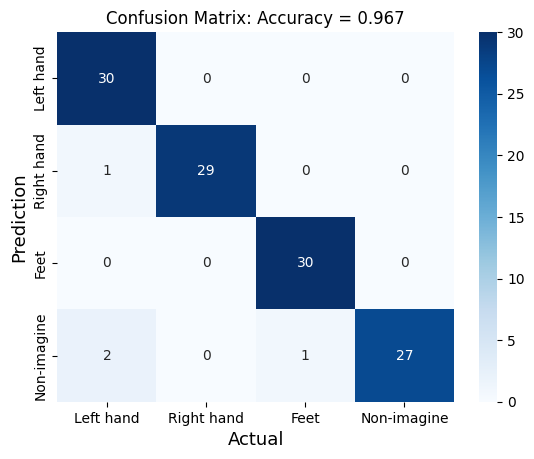

In [221]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
pretrained_model = load_model("CNN_model_weights.h5")

y_test = keras.utils.to_categorical(labels -6 , num_classes)

loss, accuracy = pretrained_model.evaluate(train_cwt_stack, y_test)

y_pred = pretrained_model.predict(train_cwt_stack)
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1)

confusion_mat = confusion_matrix(y_true, y_pred)

class_names = ['Left hand', 'Right hand', 'Feet', 'Non-imagine']

sns.heatmap(confusion_mat, 
            annot=True,
            fmt='d', 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title("Confusion Matrix: Accuracy = "+ str(round(accuracy,3)))
plt.show()